#                     BIA660 Final project-Topic detection of customer review on smart home appliances 

In [1]:
#pip install gensim

In [2]:
#pip install pyLDAvis

In [3]:
import nltk, re, json, string
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import defaultdict 
from nltk.corpus import stopwords 
import gensim
from gensim import corpora 
from gensim.models import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


### Exploring the data 

In [4]:
df = pd.read_csv('all_tineco.csv')

In [5]:
df.head()

,Account_name,Score,Title,Location,Date,Product,Purchase_Status,Review_content,Like
0,Edward L. Harwell,5.0 out of 5 stars,Best machine I have used.,the United States,14-Jul-20,Color: Ifloor3,Verified Purchase,I used my first vac 6 times before it started ...,951
1,JPG,4.0 out of 5 stars,Addictive... should. be 5 stars but.,the United States,9-Oct-20,Color: Floor One S3,Verified Purchase,After using the Tineco Floor One S3 for severa...,450
2,Martina,5.0 out of 5 stars,A time and life saver,the United States,12-Jul-20,Color: Ifloor3,Verified Purchase,This is a must have for anyone with hardwood o...,451
3,Our Best Friends Rescue Inc.,5.0 out of 5 stars,WOW! Blows the Bissell Crosswave Away,the United States,25-Sep-20,Color: Ifloor3,Verified Purchase,I was hesitant to order this machine as I was ...,330
4,MBA Squared,5.0 out of 5 stars,Cleans a variety of floors with minimal effort...,the United States,24-Jul-20,Color: Floor One S3,Verified Purchase,This is a remarkable mopper! I have used it al...,254


In [6]:
df.describe()


,Account_name,Score,Title,Location,Date,Product,Purchase_Status,Review_content,Like
count,5986,5987,5987,5987,5987,5987,5814,5973,1173
unique,4857,6,4739,6,855,4,2,5939,78
top,Amazon Customer,5.0 out of 5 stars,Love it!,the United States,30-Jun-21,iFLOOR,Verified Purchase,Love it,One
freq,513,3518,58,5919,34,2889,5813,10,695


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5987 entries, 0 to 5986
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Account_name     5986 non-null   object
 1   Score            5987 non-null   object
 2   Title            5987 non-null   object
 3   Location         5987 non-null   object
 4   Date             5987 non-null   object
 5   Product          5987 non-null   object
 6   Purchase_Status  5814 non-null   object
 7   Review_content   5973 non-null   object
 8   Like             1173 non-null   object
dtypes: object(9)
memory usage: 421.1+ KB


In [8]:
df.isnull().sum()

Account_name          1
Score                 0
Title                 0
Location              0
Date                  0
Product               0
Purchase_Status     173
Review_content       14
Like               4814
dtype: int64

In [9]:
len(df)

5987

### Raw data visualization

<Figure size 576x288 with 0 Axes>

(array([3.518e+03, 0.000e+00, 6.530e+02, 0.000e+00, 9.200e+02, 0.000e+00,
        4.360e+02, 0.000e+00, 4.590e+02, 1.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

Text(0.5, 1, 'Histogram of Score for Tineco')

Text(0.5, 15.0, 'Score')

Text(35.75, 0.5, 'Number')

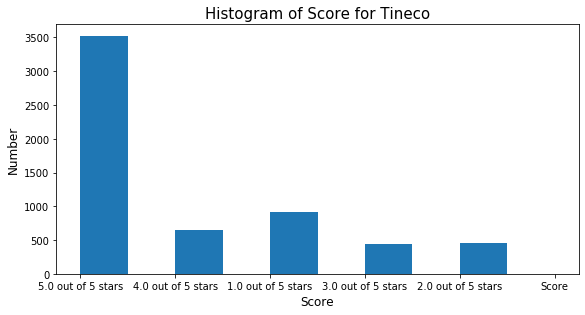

In [10]:
plt.figure(figsize=(8,4))
plt.hist(df['Score'])
plt.tight_layout()
plt.title('Histogram of Score for Tineco',fontsize =15)
plt.xlabel('Score',fontsize =12)
plt.ylabel('Number',fontsize =12)

# LDA modeling

In [11]:
df['Review_content'].head()

0    I used my first vac 6 times before it started ...
1    After using the Tineco Floor One S3 for severa...
2    This is a must have for anyone with hardwood o...
3    I was hesitant to order this machine as I was ...
4    This is a remarkable mopper! I have used it al...
Name: Review_content, dtype: object

In [12]:
reviews = df['Review_content']

In [13]:
type(reviews)

pandas.core.series.Series

### Raw Data Preprocessing

In [14]:
#remove stopwords
stopwords = nltk.corpus.stopwords.words('english')+ list(string.punctuation)
texts = [[word for word in str(document).lower().split() if word not in stopwords] for document in reviews]
#remove all punctuations
reviews = [re.sub(r'[^\w\s]','',str(item)) for item in texts]




In [15]:
#remove non-english words
words = set(nltk.corpus.words.words())
contents = str(reviews)
contents = " ".join(w for w in nltk.wordpunct_tokenize(contents) if w.lower() in words or not w.isalpha())
contents = contents.split()

In [16]:
#Text Normalization-stemming
from nltk.stem.snowball import SnowballStemmer

snow_stemmer = SnowballStemmer(language='english')
  
#stem of each word
stem_words = []
for w in contents:
    x = snow_stemmer.stem(w)
    stem_words.append(x)
pre_texts = stem_words

### using sklearn

#### Preprocessing - Create Term Frequency Matrix

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
#remove all punctuations and stopwords
stopwords = nltk.corpus.stopwords.words('english')+ list(string.punctuation)
tf_vectorizer = CountVectorizer(min_df=5, stop_words=stopwords)
tf = tf_vectorizer.fit_transform(pre_texts)
tf_feature_names = tf_vectorizer.get_feature_names()
X_train, X_test = train_test_split(\
                tf, test_size=0.1, random_state=0)

#### Extract topics

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 8
# max_iter control the number of iterations 
# evaluate_every determines how often the perplexity is calculated
# n_jobs is the number of parallel threads
lda = LatentDirichletAllocation(n_components=num_topics, \
                                max_iter=30,verbose=1,
                                evaluate_every=1, n_jobs=1,
                                random_state=0).fit(X_train)

iteration: 1 of max_iter: 30, perplexity: 864.9295
iteration: 2 of max_iter: 30, perplexity: 518.6271
iteration: 3 of max_iter: 30, perplexity: 505.7424
iteration: 4 of max_iter: 30, perplexity: 503.6818
iteration: 5 of max_iter: 30, perplexity: 503.6468


In [19]:
num_top_words=20
for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx))
    words=[(tf_feature_names[i],'%.2f'%topic[i]) \
           for i in topic.argsort()[::-1][0:num_top_words]]
    print(words)
    print("\n")

Topic 0:
[('work', '1627.12'), ('get', '1500.12'), ('realli', '807.12'), ('thing', '781.12'), ('back', '655.12'), ('everi', '646.12'), ('need', '640.12'), ('leav', '624.12'), ('job', '568.12'), ('hardwood', '493.12'), ('money', '462.12'), ('two', '446.12'), ('could', '376.12'), ('see', '331.12'), ('enough', '325.12'), ('made', '311.12'), ('whole', '282.12'), ('live', '260.12'), ('left', '259.12'), ('custom', '236.12')]


Topic 1:
[('mop', '1554.12'), ('dirti', '1198.12'), ('cleaner', '660.12'), ('littl', '608.12'), ('self', '594.12'), ('amaz', '593.12'), ('dri', '565.12'), ('small', '519.12'), ('worth', '507.12'), ('quick', '433.12'), ('purchas', '365.12'), ('light', '342.12'), ('absolut', '310.12'), ('kitchen', '300.12'), ('far', '266.12'), ('sinc', '238.12'), ('old', '237.12'), ('replac', '214.12'), ('lightweight', '200.12'), ('put', '195.12')]


Topic 2:
[('clean', '5721.12'), ('vacuum', '1724.12'), ('easi', '1403.12'), ('product', '1035.12'), ('machin', '959.12'), ('even', '727.12'

In [20]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 12})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=18)
    plt.show()

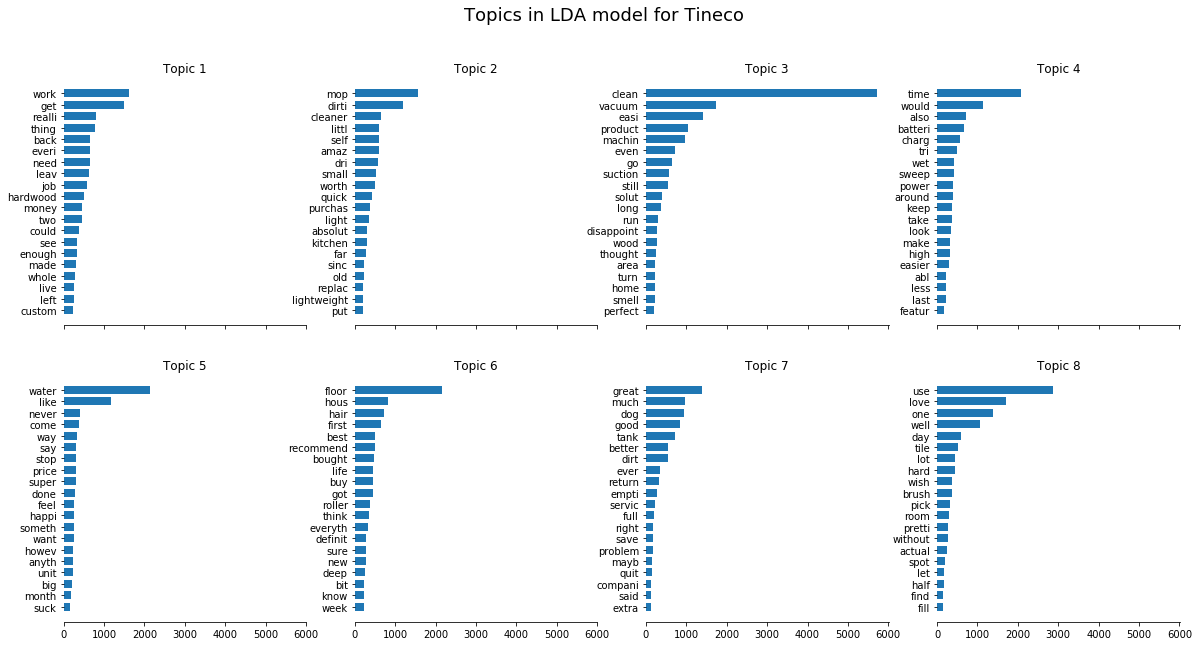

In [21]:
for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[: -num_top_words - 1 : -1]
        top_features = [tf_feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]


plot_top_words(lda, tf_feature_names, num_top_words, "Topics in LDA model for Tineco")

In [22]:
topic_n = []
word_dict = []
for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[: -num_top_words - 1 : -1]
        top_features = [tf_feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        topic_n.append("Topic %d" % (topic_idx+1))
        word_dict.append(top_features)

tw = pd.DataFrame(word_dict,index = topic_n)
#tw_transposed = tw.T
#tw_transposed
tw

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic 1,work,get,realli,thing,back,everi,need,leav,job,hardwood,money,two,could,see,enough,made,whole,live,left,custom
Topic 2,mop,dirti,cleaner,littl,self,amaz,dri,small,worth,quick,purchas,light,absolut,kitchen,far,sinc,old,replac,lightweight,put
Topic 3,clean,vacuum,easi,product,machin,even,go,suction,still,solut,long,run,disappoint,wood,thought,area,turn,home,smell,perfect
Topic 4,time,would,also,batteri,charg,tri,wet,sweep,power,around,keep,take,look,make,high,easier,abl,less,last,featur
Topic 5,water,like,never,come,way,say,stop,price,super,done,feel,happi,someth,want,howev,anyth,unit,big,month,suck
Topic 6,floor,hous,hair,first,best,recommend,bought,life,buy,got,roller,think,everyth,definit,sure,new,deep,bit,know,week
Topic 7,great,much,dog,good,tank,better,dirt,ever,return,empti,servic,full,right,save,problem,mayb,quit,compani,said,extra
Topic 8,use,love,one,well,day,tile,lot,hard,wish,brush,pick,room,pretti,without,actual,spot,let,half,find,fill


In [23]:
#pip install dataframe_image

In [24]:
import dataframe_image as dfi
dfi.export(tw,"Tineco_1.png")

In [25]:
#pip install wordcloud

#### Visualization using wordcloud

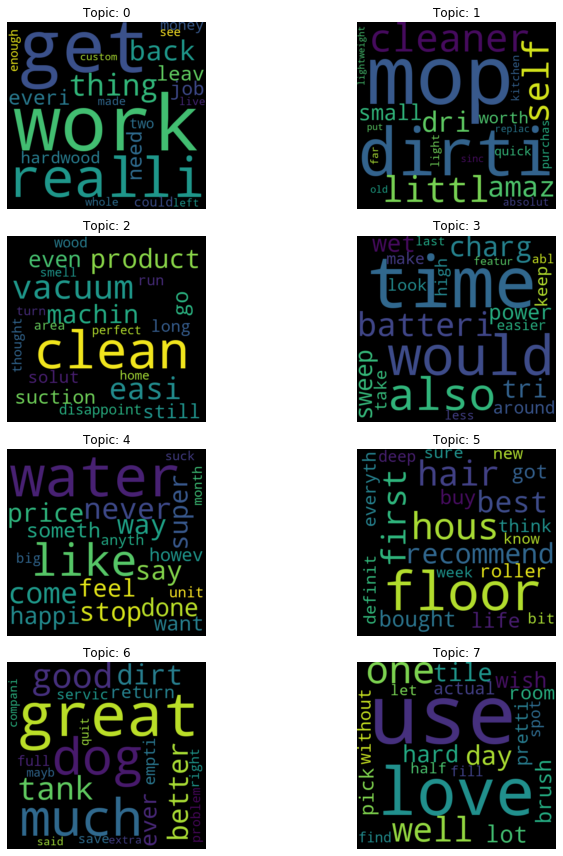

In [26]:
from wordcloud import WordCloud
import math

num_top_words=20
f, axarr = plt.subplots(4, 2, figsize=(12, 12));

for topic_idx, topic in enumerate(lda.components_):
    # create a dataframe with two columns (word, weight) for each topic
    
    # create a word:count dictionary
    f={tf_feature_names[i]:topic[i] for i in topic.argsort()[::-1][0:num_top_words]}
    
    # generate wordcloud in subplots
    wordcloud = WordCloud(width=480, height=450, margin=0, background_color="black");
    _ = wordcloud.generate_from_frequencies(frequencies=f);
    
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].imshow(wordcloud, interpolation="bilinear");
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].set_title("Topic: "+str(topic_idx));
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].axis('off')

plt.tight_layout()
plt.show()

#### Visualization using PyLDAvis

In [27]:
display = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.display(display)

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### using gensim

#### Turning text to dictionary

In [28]:
dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(19005 unique tokens: ['$300', '1', '3', '4', '5']...)


In [29]:
corpus = [dictionary.doc2bow(text) for text in texts]


#### Extracting Topics

In [30]:
num_topics = 8
ldamodel = LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=15)


In [31]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.009*"back" + 0.009*"customer" + 0.008*"one" + 0.008*"get" + 0.008*"return" + 0.008*"even" + 0.007*"product" + 0.007*"stopped" + 0.007*"tineco" + 0.007*"service"')
(1, '0.042*"best" + 0.033*"ever" + 0.018*"thing" + 0.011*"love" + 0.011*"purchase" + 0.010*"it!" + 0.010*"loves" + 0.008*"i‚äôve" + 0.007*"bought" + 0.006*"buy"')
(2, '0.016*"water" + 0.011*"vacuum" + 0.010*"dirty" + 0.009*"bissell" + 0.008*"would" + 0.007*"crosswave" + 0.006*"tank" + 0.005*"tineco" + 0.004*"suction" + 0.004*"better"')
(3, '0.020*"clean" + 0.013*"floors" + 0.013*"cleaning" + 0.011*"water" + 0.011*"use" + 0.010*"love" + 0.010*"floor" + 0.009*"easy" + 0.008*"vacuum" + 0.008*"mop"')
(4, '0.011*"love" + 0.007*"works" + 0.005*"it." + 0.005*"crosswave" + 0.005*"really" + 0.004*"vacuum" + 0.004*"product!" + 0.003*"worth" + 0.003*"absolutely" + 0.003*"use"')
(5, '0.005*"floor" + 0.005*"good" + 0.003*"wish" + 0.003*"best." + 0.003*"like" + 0.003*"edge" + 0.002*"wall." + 0.002*"doesnt" + 0.002*"awesome" + 0.002*

In [32]:
word_dict = {};
for i in range(num_topics):
    words = ldamodel.show_topic(i, topn = 20)
    word_dict['Topic ' + '{:2d}'.format(i+1)] = [i[0] for i in words]
wd = pd.DataFrame(word_dict)
wd_transposed = wd.T
wd_transposed
dfi.export(wd_transposed,"Tineco_2.png")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic 1,back,customer,one,get,return,even,product,stopped,tineco,service,would,first,it.,months,machine,got,work,worked,working,water
Topic 2,best,ever,thing,love,purchase,it!,loves,i‚äôve,bought,buy,worth,ever.,amazing,wife,made,absolutely,made.,money,know,without
Topic 3,water,vacuum,dirty,bissell,would,crosswave,tank,tineco,suction,better,one,brush,floor,like,pet,good,works,price,power,well
Topic 4,clean,floors,cleaning,water,use,love,floor,easy,vacuum,mop,it‚äôs,like,get,time,great,dirty,much,would,one,really
Topic 5,love,works,it.,crosswave,really,vacuum,product!,worth,absolutely,use,i‚äôm,far,rug,great,machine.,!!,returning.,tineco.,happy,money.
Topic 6,floor,good,wish,best.,like,edge,wall.,doesnt,awesome,mop,had.,others,build,game,s3,vac,understand,sticky,spent!,recommended.
Topic 7,love,cross,wave,"love,",:(,nan,this!,construction,wave.,"much,",absolutely,return.,satisfied.,lines.,market,it!!!,shipped,boyfriend,daily!,power
Topic 8,pee,leaked,becomes,like.,vacuum/mop.,brush.,children.,"together,",dollars,"advertised,","buy,",scratched,wets,useful.,delivery,essentially,wine,frustrated,easier!!,beware


In [33]:
# coherence score
from gensim.models import CoherenceModel
coherence_model_lda=CoherenceModel(model=ldamodel,texts=texts,dictionary=dictionary,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Score:',coherence_lda)


Coherence Score: 0.46307834737647424


#### Visualization using PyLDAvis

In [34]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)


/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


### Hyperparameter Tuning - Number of Topics and Alpha

#### (1)Evaluate Topic Model using Perplexity and find the the number of topics

Text(0.5, 0, 'num_topics')

Text(0, 0.5, 'perplexity score')

Text(0.5, 1.0, 'Tineco number of topic - perplexity score')

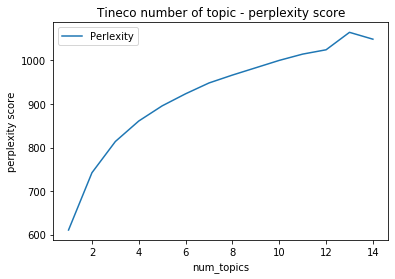

In [35]:

result=[]
for num_topics in range(1,15):
    lda = LatentDirichletAllocation(n_components=num_topics, \
                                learning_method='online', \
                                max_iter=30,verbose=0, n_jobs=1,
                                random_state=0).fit(X_train)
    p=lda.perplexity(X_test)
    result.append([num_topics,p])
    
num_p = pd.DataFrame(result, columns=["num_topics", "Perlexity"])
num_p.plot.line(x='num_topics',y="Perlexity")
plt.xlabel('num_topics')
plt.ylabel('perplexity score')
plt.title('Tineco number of topic - perplexity score')
plt.show()

A lower perplexity score indicates better generalization performance

#### (2)compute coherence value at various values of alpha and num_topics

In [40]:
def compute_coherence_values(dictionary, corpus, texts, num_topics_range,alpha_range):
    coherence_values=[]
    model_list=[]
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, alpha=alpha,num_topics=num_topics,\
                                                      per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel=CoherenceModel(model=lda_model,texts=texts,dictionary=dictionary,coherence='c_v')
            coherence_values.append((alpha,num_topics,coherencemodel.get_coherence()))
    return model_list,coherence_values


In [41]:
# build models accross a range of num_topics and alpha
num_topics_range= range(1,15)
alpha_range=[0.01,0.1,1]
model_list, coherence_values= compute_coherence_values(dictionary=dictionary,corpus=corpus,texts=texts,\
                                                       num_topics_range=num_topics_range,alpha_range=alpha_range)


In [42]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,1,0.419276
1,0.01,2,0.425323
2,0.01,3,0.404580
3,0.01,4,0.406364
4,0.01,5,0.409826
5,0.01,6,0.393553
6,0.01,7,0.413402
7,0.01,8,0.403923
8,0.01,9,0.402136
9,0.01,10,0.381147


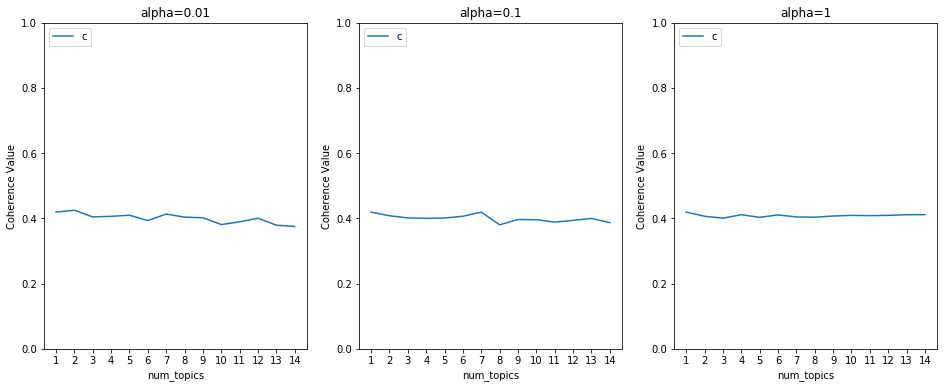

In [43]:
# plot the relationship between alpha, number of topics and coherence value
def plot_coherence(coherence_df,alpha_range,num_topics_range):
    plt.figure(figsize=(16,6))
    
    for i,val in enumerate(alpha_range):
        #subolot 1/3/i
        plt.subplot(1,3,i+1)
        alpha_subset=coherence_df[coherence_df['alpha']==val]
        plt.plot(alpha_subset['num_topics'],alpha_subset['coherence_value'])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title('alpha={0}'.format(val))
        plt.ylim([0,1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)
plot_coherence(coherence_df,alpha_range,num_topics_range)